In [1]:
import os
import sys

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(notebook_dir)

if project_dir not in sys.path:
    sys.path.append(project_dir)

# Read Data

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Import Data
import pandas as pd
tweets_df = pd.read_csv(r"C:\Users\johna\anaconda3\envs\twitter-influence-env\twitter-influence\data\01_raw\top_accounts_details.csv")
tweets_df['date'] = pd.to_datetime(tweets_df['creation_date'], format='%a %b %d %H:%M:%S +0000 %Y')
tweets_df['month_year'] = tweets_df['date'].apply(lambda x: x.strftime('%Y-%m'))
tweets_df['date_day'] = tweets_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

tweets_df = tweets_df.loc[tweets_df['follower_count'] > 0]

# calculate per follower metrics 
tweets_df['favorite_count_pf'] = tweets_df['favorite_count']/ tweets_df['follower_count']
tweets_df['retweet_count_pf'] = tweets_df['retweet_count']/ tweets_df['follower_count']
tweets_df['quote_count_pf'] = tweets_df['quote_count']/ tweets_df['follower_count']
tweets_df['reply_count_pf'] = tweets_df['reply_count']/ tweets_df['follower_count']

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(tweets_df[['favorite_count_pf', 'retweet_count_pf', 'quote_count_pf', 'reply_count_pf']])
tweets_df[['favorite_count_pf', 'retweet_count_pf', 'quote_count_pf', 'reply_count_pf']] = scaled_values

tweets_df = tweets_df.loc[tweets_df['language']=='en']


# Sentiment & Emotion Analysis

In [3]:
from scripts.text_processing.sentiment_analysis import SentimentAnalyzer

# sentiment analyser, specify model
analyzer = SentimentAnalyzer('cardiffnlp/twitter-roberta-base-sentiment-latest')

# Get sentiment analysis
tweets_with_sentiment = analyzer.get_sentiment(tweets_df)


C:\Users\johna\anaconda3\envs\twitter-influence-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# sentiment analyser, specify model
analyzer = SentimentAnalyzer('cardiffnlp/twitter-roberta-base-emotion', emotion=True)

# Get sentiment analysis
tweets_with_sentiment = analyzer.get_sentiment(tweets_with_sentiment)


# Summarise at user level for clustering

In [5]:
sentiment_ratios = pd.crosstab(
    index=tweets_with_sentiment['user_id'],
    columns= tweets_with_sentiment['sentiment'],
    normalize='index'
).reset_index()


emotion_ratios = pd.crosstab(
    index=tweets_with_sentiment['user_id'],
    columns= tweets_with_sentiment['emotion'],
    normalize='index'
).reset_index()


ratios_emotion_sentiment = emotion_ratios.merge(sentiment_ratios, on='user_id')


influence_metrics = tweets_with_sentiment.groupby('user_id').agg(
    {
        'name': [lambda x: x.mode().iloc[0] if not x.mode().empty else None],
        'favorite_count_pf': ['mean'],
        'retweet_count_pf': ['mean'],
        'quote_count_pf': ['mean'],
        'reply_count_pf': ['mean'],
        'tweet_id': ['count'],
        'follower_count': ['mean'],
        'date_day': [lambda x: x.nunique()]



    }
)

# Calculate the average daily tweets
influence_metrics['avg_daily_tweets'] = influence_metrics[('tweet_id', 'count')] / influence_metrics[('date_day', '<lambda>')]

# Flatten the MultiIndex columns
influence_metrics.columns = ['_'.join(col).strip() for col in influence_metrics.columns.values]
# Reset the index to move the 'username' back to a column
influence_metrics.reset_index(inplace=True)
influence_metrics_final = influence_metrics.merge(right=ratios_emotion_sentiment, how='left', left_on='user_id', right_on='user_id')
influence_metrics_final.rename(columns={'name_<lambda>':'name', 'follower_count_mean':'followers', 'avg_daily_tweets_': 'average daily tweets'}, inplace=True)
influence_metrics_final

,user_id,name,favorite_count_pf_mean,retweet_count_pf_mean,quote_count_pf_mean,reply_count_pf_mean,tweet_id_count,followers,date_day_<lambda>,average daily tweets,anger,joy,optimism,sadness,negative,neutral,positive
0,428333,CNN Breaking News,1.249635e-09,2.120927e-09,2.734203e-08,1.854789e-08,96,6.412692e+07,27,3.555556,0.166667,0.333333,0.062500,0.437500,0.312500,0.666667,0.020833
1,742143,BBC News (World),1.205793e-09,1.432925e-09,1.218120e-08,1.318765e-08,89,3.969302e+07,2,44.500000,0.044944,0.303371,0.325843,0.325843,0.213483,0.707865,0.078652
2,759251,CNN,1.111227e-09,1.711755e-09,2.176885e-08,2.348811e-08,97,6.130561e+07,2,48.500000,0.144330,0.278351,0.288660,0.288660,0.226804,0.649485,0.123711
3,783214,Twitter,3.798663e-07,2.730519e-07,5.476387e-06,1.331166e-06,78,6.489580e+07,60,1.300000,0.269231,0.205128,0.448718,0.076923,0.089744,0.641026,0.269231
4,807095,The New York Times,1.180996e-09,2.222673e-09,1.387809e-08,1.084889e-08,82,5.499163e+07,2,41.000000,0.256098,0.158537,0.292683,0.292683,0.268293,0.536585,0.195122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,866953267,Cardi B,3.339911e-04,1.227827e-04,4.363027e-04,4.359926e-04,52,2.260202e+07,37,1.405405,0.076923,0.269231,0.500000,0.153846,0.288462,0.288462,0.423077
92,1339835893,Hillary Clinton,6.120861e-06,5.576989e-06,2.304019e-05,4.026735e-05,79,2.321191e+07,57,1.385965,0.455696,0.189873,0.265823,0.088608,0.215190,0.151899,0.632911
93,1409798257,BTS_official,8.044881e-07,1.553500e-06,1.509323e-06,3.825196e-07,28,4.281072e+07,15,1.866667,0.000000,0.000000,1.000000,0.000000,0.000000,0.678571,0.321429
94,1447949844,Amit Shah,3.388176e-08,6.060296e-08,1.533872e-08,3.753867e-08,35,3.094562e+07,5,7.000000,0.628571,0.000000,0.342857,0.028571,0.028571,0.142857,0.828571


# Clustering

In [6]:
from scripts.clustering.cluster import ClusterAnalysis

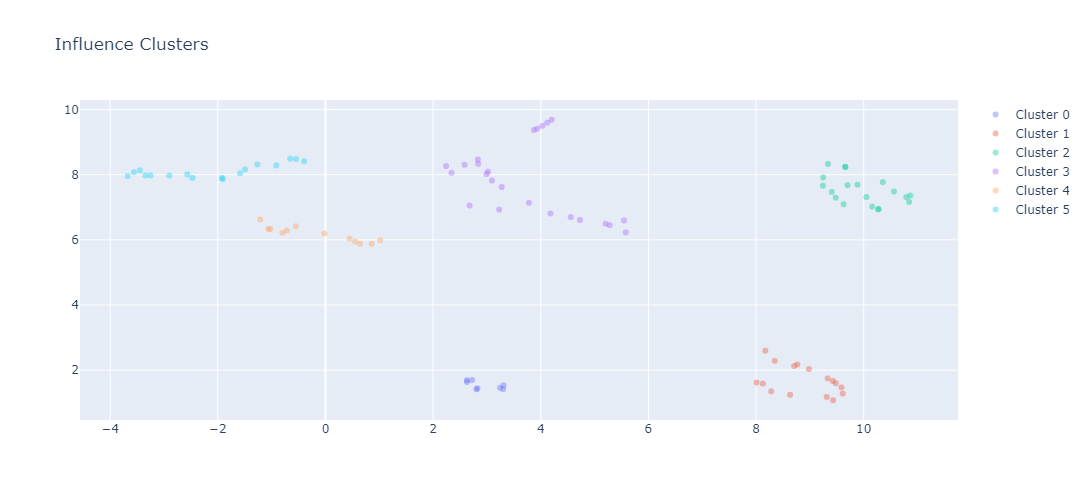

In [40]:
# Create a sample DataFrame
df = influence_metrics_final

# Run UmapHdbscanBokeh
ca = ClusterAnalysis(df, n_neighbors=5, min_cluster_size=5, min_dist=0.09, metric='euclidean')
ca.run()

# Analyse Clusters

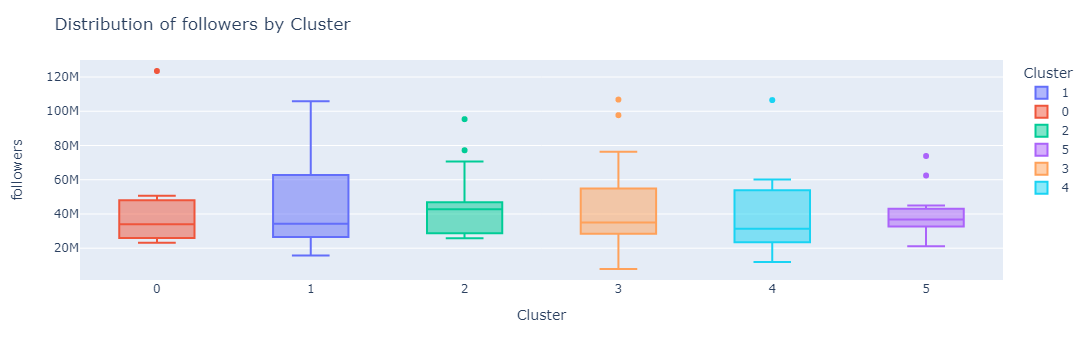

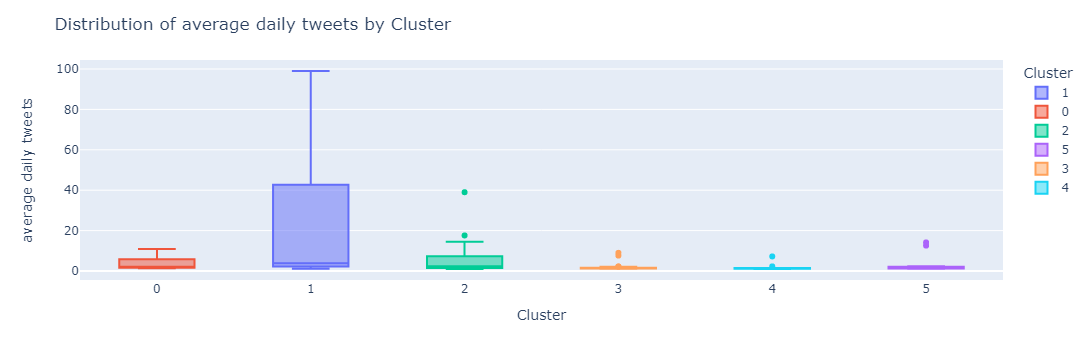

In [41]:
import plotly.express as px

analysis_df = pd.read_csv(r"C:\Users\johna\anaconda3\envs\twitter-influence-env\twitter-influence\data\02_intermediate\tweet_analysis_data.csv")


# Create a list of the columns you want to plot distributions for
columns_to_plot = ['followers', 'average daily tweets']

# Iterate over the columns and create a distribution plot for each
for column in columns_to_plot:
    fig = px.box(analysis_df, x="cluster", y=column, color="cluster")
    fig.update_layout(
        title=f"Distribution of {column} by Cluster",
        xaxis_title="Cluster",
        yaxis_title=column,
        legend_title="Cluster",
    )
    fig.show()

In [42]:
# Create a contingency table with counts of positive and non-positive samples for each cluster
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

tweet_level_metrics = tweets_with_sentiment.merge(how='left', right=analysis_df[['user_id', 'cluster']], left_on='user_id', right_on='user_id')


def run_chisquare_analysis(df, var):
    contingency_table = pd.crosstab(df['cluster'], df[var])

    # Perform the Chi-square test
    chi2_stat, p_value, dof, ex = chi2_contingency(contingency_table)

    # Calculate the standardized residuals
    standardized_residuals = (contingency_table - ex) / np.sqrt(ex)
    
    #standardized_residuals.index.name = None
    standardized_residuals = standardized_residuals.reset_index()

    print("Chi2 Stat:", chi2_stat)
    print("P Value:", p_value)
    print("Degrees of Freedom:", dof)
    # print("Expected Frequency Table:")
    # print(ex)

    return standardized_residuals

In [43]:
standardized_residuals_emotion = run_chisquare_analysis(df=tweet_level_metrics, var='emotion')
standardized_residuals_emotion

Chi2 Stat: 2291.231680297807
P Value: 0.0
Degrees of Freedom: 15


emotion,cluster,anger,joy,optimism,sadness
0,0,26.996266,0.282754,-12.757279,-2.317548
1,1,3.817069,17.572864,-14.152016,16.394102
2,2,-8.456980,-5.046660,7.708368,-4.620196
3,3,-6.561796,-1.297476,4.247726,-1.398596
4,4,3.298702,-6.220708,2.234836,-4.532003
5,5,-9.619177,-7.650203,9.775780,-6.130738


In [44]:
standardized_residuals_sentiment = run_chisquare_analysis(df=tweet_level_metrics, var='sentiment')
standardized_residuals_sentiment

Chi2 Stat: 1535.7881575074448
P Value: 0.0
Degrees of Freedom: 10


sentiment,cluster,negative,neutral,positive
0,0,1.465019,-4.680520,3.089502
1,1,15.927987,13.728492,-16.759989
2,2,-8.009007,12.648892,-6.807765
3,3,0.358029,-5.348576,4.031406
4,4,-4.716698,-10.365907,9.872537
5,5,-6.965723,-9.402372,9.977770


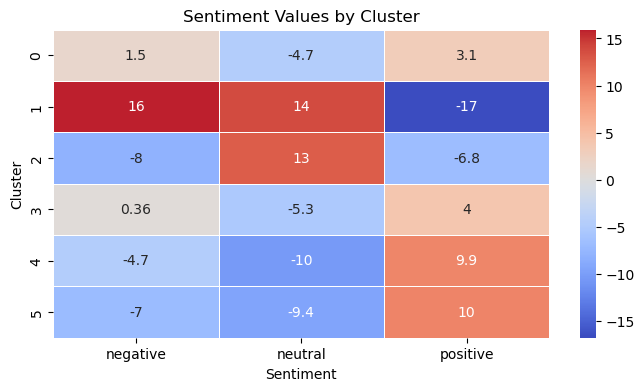

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for the heatmap
heatmap_data = standardized_residuals_sentiment.set_index('cluster')[['negative', 'neutral', 'positive']]

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
plt.title('Sentiment Values by Cluster')
plt.xlabel('Sentiment')
plt.ylabel('Cluster')
plt.show()



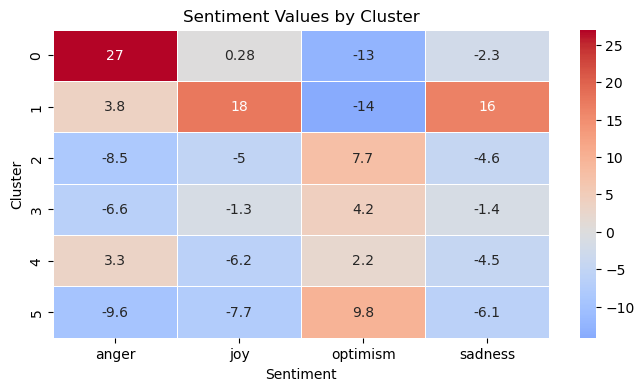

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for the heatmap
heatmap_data = standardized_residuals_emotion.set_index('cluster')[['anger', 'joy', 'optimism', 'sadness']]

# Create the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
plt.title('Sentiment Values by Cluster')
plt.xlabel('Sentiment')
plt.ylabel('Cluster')
plt.show()

In [47]:
# who's in the clusters 

cluster_0 = analysis_df.loc[analysis_df['cluster']==0]['name']
cluster_0

5        Barack Obama
6           Joe Biden
48         Bill Gates
72        Emma Watson
87          PMO India
92    Hillary Clinton
94          Amit Shah
95    President Biden
Name: name, dtype: object

In [48]:
cluster_1 = analysis_df.loc[analysis_df['cluster']==1]['name']
cluster_1

0       CNN Breaking News
1        BBC News (World)
2                     CNN
3                 Twitter
4      The New York Times
7                 Reuters
9       BBC Breaking News
10          The Economist
19    National Geographic
26            Wiz Khalifa
33    Kourtney Kardashian
34        Donald J. Trump
45            Nicki Minaj
46              Elon Musk
62          Conan O'Brien
91                Cardi B
Name: name, dtype: object

In [49]:
cluster_2 = analysis_df.loc[analysis_df['cluster']==2]['name']
cluster_2

8                      ESPN
11                  YouTube
12              PlayStation
13                     NASA
15         Real Madrid C.F.
24                      NFL
25                      NBA
36             SportsCenter
38                   Drizzy
39            Justin Bieber
43                   SpaceX
56             FC Barcelona
73             BIGHIT MUSIC
77                    Adele
79              Whindersson
80            netflixbrasil
82              Miley Cyrus
90    UEFA Champions League
93             BTS_official
Name: name, dtype: object

In [50]:
cluster_3 = analysis_df.loc[analysis_df['cluster']==3]['name']
cluster_3

16         Jimmy Fallon
17      Ellen DeGeneres
20         Taylor Swift
21             PRIYANKA
23        Oprah Winfrey
28          Demi Lovato
29           KATY PERRY
30         LeBron James
32         Selena Gomez
37    Justin Timberlake
42                Khloé
47              Shakira
51              Rihanna
57           Bruno Mars
58       Shah Rukh Khan
61       Hrithik Roshan
63    Lil Wayne WEEZY F
69              Kendall
70                 Liam
71            Neymar Jr
74                 zayn
75            Instagram
78        One Direction
85         Shawn Mendes
Name: name, dtype: object

In [51]:
cluster_4 = analysis_df.loc[analysis_df['cluster']==4]['name']
cluster_4

18      Britney Spears 🌹🚀
22          Narendra Modi
27                 Google
49                   Kaka
50            Virat Kohli
54    Neil Patrick Harris
55         Andrés Iniesta
66       Sachin Tendulkar
67       Amitabh Bachchan
68      Cristiano Ronaldo
86        Arvind Kejriwal
88             Mesut Özil
Name: name, dtype: object

In [52]:
cluster_5 = analysis_df.loc[analysis_df['cluster']==5]['name']
cluster_5

14            Lady Gaga
31           Kevin Hart
35       Kim Kardashian
40                 P!nk
41         Akshay Kumar
44          Alicia Keys
52      Louis Tomlinson
53                  jlo
59     Deepika Padukone
60          Niall Horan
64          Chris Brown
65          Salman Khan
76        Harry Styles.
81         Kylie Jenner
83                방탄소년단
84       Premier League
89    Manchester United
Name: name, dtype: object